<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install EasyFSL

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 942.4 kB/s eta 0:00:00


### Download Humpback Whale Identification dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification

100% 5.49G/5.51G [01:03<00:00, 164MB/s]
100% 5.51G/5.51G [01:03<00:00, 92.4MB/s]


In [6]:
%%capture

!unzip humpback-whale-identification.zip

### Clone GitHub repo

In [7]:
!git clone https://github.com/jwells52/creating-ai-enabled-systems.git
%cd creating-ai-enabled-systems/Research\ Project

Cloning into 'creating-ai-enabled-systems'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 289 (delta 60), reused 23 (delta 7), pack-reused 187
Receiving objects: 100% (289/289), 158.95 MiB | 26.66 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Updating files: 100% (48/48), done.
/content/creating-ai-enabled-systems/Research Project


### Imports

In [8]:
import os

import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
# from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loaders
from modules.train import train_fsl, device, transform
from modules.plotting import fsl_plots


### Load dataset

In [9]:
train_df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/training_10samples.csv')
)

valid_df = remove_new_whale_class(
    pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/validation_10samples.csv')
)


In [10]:
print(f"Min # of samples for a class in training set = {train_df['class_count'].min()}")
print(f"Max # of samples for a class in training set = {train_df['class_count'].max()}")
print(f"# of classes in training set = {len(train_df['Id'].unique())}")


Min # of samples for a class in training set = 11
Max # of samples for a class in training set = 73
# of classes in training set = 181


In [11]:
print(f"Min # of samples for a class in validation set = {valid_df['class_count'].min()}")
print(f"Max # of samples for a class in validation set = {valid_df['class_count'].max()}")
print(f"# of classes in validation set = {len(valid_df['Id'].unique())}")

Min # of samples for a class in validation set = 11
Max # of samples for a class in validation set = 48
# of classes in validation set = 46


### Set up PyTorch Dataset

In [12]:
train_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=train_df,
    transform=transform
)

valid_set = HumpbackWhaleDataset(
    image_dir='/content/train',
    labels=valid_df,
    transform=transform
)

In [13]:
# Define learning rate and epochs
n_epochs = 25
learning_rate = 1e-2

# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 100

# Number of Validation tasks for evaluation during training
n_validation_tasks = 45

n_way   = 5
n_shot  = 5
n_query = 5

In [15]:
train_loader, valid_loader = create_loaders(
    train_set, valid_set,
    n_way,
    n_shot,
    n_query,
    n_task_per_epoch,
    n_validation_tasks
)

### Train Prototypical Network with ResNet18, ResNet34, and ResNet152 as the feature extractor

In [16]:
# Train a fsl model with different backbones

backbones = ['resnet18', 'resnet34', 'resnet152']

train_loss_dict = dict()
valid_acc_dict  = dict()
for backbone in backbones:
  print(f'Training and Evaluating {backbone} as feature extractor')
  cnn = torch.hub.load('pytorch/vision:v0.10.0', backbone, pretrained=True)
  cnn.fc = torch.nn.Flatten()
  cnn = cnn.to(device)

  few_shot_classifier = PrototypicalNetworks(cnn).to(device)
  loss_fn = torch.nn.CrossEntropyLoss()
  optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)


  train_losses, valid_accs = train_fsl(
      few_shot_classifier,
      train_loader,
      valid_loader,
      optimizer,
      loss_fn,
      n_epochs=n_epochs,
      use_tqdm=True,
      save_model=False
  )

  train_loss_dict[backbone] = train_losses
  valid_acc_dict[backbone]  = valid_accs

Training and Evaluating resnet18 as feature extractor


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]



Epoch 1 

Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.861]


Epoch 2 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.09s/it, accuracy=0.91]


Epoch 3 


Validation: 100%|██████████| 45/45 [00:45<00:00,  1.00s/it, accuracy=0.94]


Epoch 4 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.03s/it, accuracy=0.939]


Epoch 5 


Validation: 100%|██████████| 45/45 [00:45<00:00,  1.01s/it, accuracy=0.942]


Epoch 6 


Validation: 100%|██████████| 45/45 [00:45<00:00,  1.01s/it, accuracy=0.963]


Epoch 7 


Validation: 100%|██████████| 45/45 [00:45<00:00,  1.01s/it, accuracy=0.948]


Epoch 8 


Validation: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it, accuracy=0.943]


Epoch 9 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.03s/it, accuracy=0.944]


Epoch 10 


Validation: 100%|██████████| 45/45 [00:45<00:00,  1.01s/it, accuracy=0.968]


Epoch 11 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.03s/it, accuracy=0.956]


Epoch 12 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.04s/it, accuracy=0.956]


Epoch 13 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.04s/it, accuracy=0.964]


Epoch 14 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.04s/it, accuracy=0.957]


Epoch 15 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.955]


Epoch 16 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.05s/it, accuracy=0.954]


Epoch 17 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.04s/it, accuracy=0.97]


Epoch 18 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.03s/it, accuracy=0.957]


Epoch 19 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.05s/it, accuracy=0.966]


Epoch 20 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.971]


Epoch 21 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.07s/it, accuracy=0.972]


Epoch 22 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.08s/it, accuracy=0.967]


Epoch 23 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.08s/it, accuracy=0.975]


Epoch 24 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.956]


Epoch 25 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.08s/it, accuracy=0.95]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Saving state of model checkpoint at last epoch to /content/drive/MyDrive/prototypical_network_resnet12_last_epoch
Training and Evaluating resnet34 as feature extractor


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 58.2MB/s]



Epoch 1 

Validation: 100%|██████████| 45/45 [00:46<00:00,  1.04s/it, accuracy=0.854]


Epoch 2 


Validation: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it, accuracy=0.884]


Epoch 3 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.938]


Epoch 4 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.03s/it, accuracy=0.949]


Epoch 5 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.952]


Epoch 6 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.04s/it, accuracy=0.957]


Epoch 7 


Validation: 100%|██████████| 45/45 [00:46<00:00,  1.03s/it, accuracy=0.96]


Epoch 8 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.96]


Epoch 9 


Validation: 100%|██████████| 45/45 [00:51<00:00,  1.14s/it, accuracy=0.934]


Epoch 10 


Validation: 100%|██████████| 45/45 [00:47<00:00,  1.06s/it, accuracy=0.966]


Epoch 11 


Validation: 100%|██████████| 45/45 [00:49<00:00,  1.09s/it, accuracy=0.948]


Epoch 12 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.08s/it, accuracy=0.966]


Epoch 13 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.08s/it, accuracy=0.972]


Epoch 14 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.07s/it, accuracy=0.949]


Epoch 15 


Validation: 100%|██████████| 45/45 [00:49<00:00,  1.10s/it, accuracy=0.972]


Epoch 16 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.08s/it, accuracy=0.965]


Epoch 17 


Validation: 100%|██████████| 45/45 [00:49<00:00,  1.09s/it, accuracy=0.962]


Epoch 18 


Validation: 100%|██████████| 45/45 [00:48<00:00,  1.08s/it, accuracy=0.968]


Epoch 19 


Validation: 100%|██████████| 45/45 [00:49<00:00,  1.09s/it, accuracy=0.966]


Epoch 20 


Validation: 100%|██████████| 45/45 [00:49<00:00,  1.09s/it, accuracy=0.955]


Epoch 21 


Validation: 100%|██████████| 45/45 [00:50<00:00,  1.12s/it, accuracy=0.962]


Epoch 22 


Validation: 100%|██████████| 45/45 [00:50<00:00,  1.12s/it, accuracy=0.958]


Epoch 23 


Validation: 100%|██████████| 45/45 [00:50<00:00,  1.13s/it, accuracy=0.967]


Epoch 24 


Validation: 100%|██████████| 45/45 [00:51<00:00,  1.14s/it, accuracy=0.964]


Epoch 25 


Validation: 100%|██████████| 45/45 [00:50<00:00,  1.12s/it, accuracy=0.966]


Saving state of model checkpoint at last epoch to /content/drive/MyDrive/prototypical_network_resnet12_last_epoch
Training and Evaluating resnet152 as feature extractor


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:04<00:00, 55.2MB/s]



Epoch 1 

Training:   0%|          | 0/100 [00:05<?, ?it/s]


OutOfMemoryError: ignored

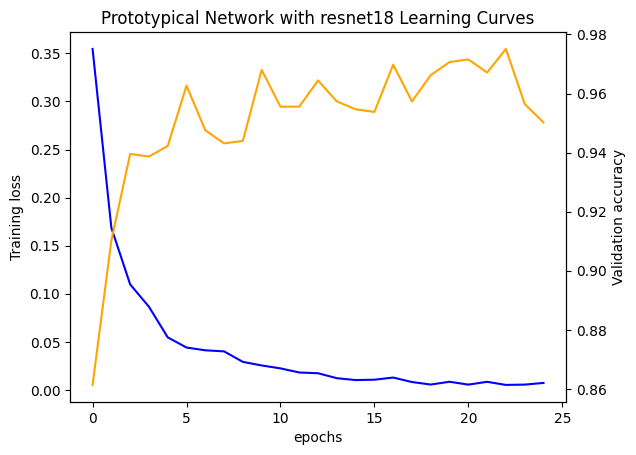

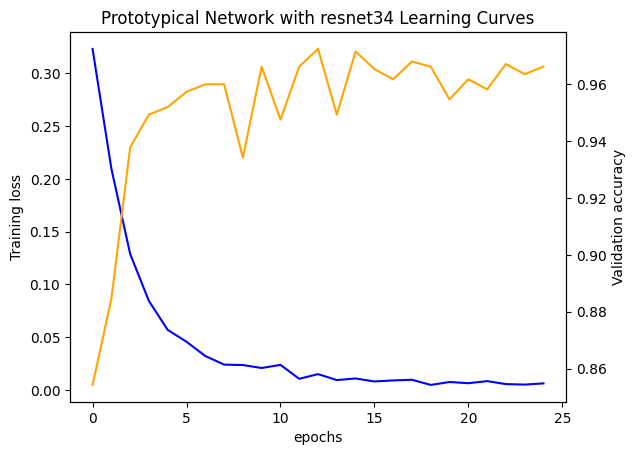

In [21]:
for backbone in backbones[:-1]:
  fig,ax = plt.subplots()

  plt.title(f'Prototypical Network with {backbone} Learning Curves')

  ax.plot(train_loss_dict[backbone], color='blue')
  ax.set_xlabel("epochs")
  ax.set_ylabel('Training loss')

  ax2=ax.twinx()
  ax2.plot(valid_acc_dict[backbone], color='orange')
  ax2.set_ylabel('Validation accuracy')

  plt.show()
  fig.savefig(f'/content/prototypical_network_{backbone}_learning_curves_100epochs.png', format='png')

# 5-fold cross validation for the following shots

* 1-shot 10-way
* 5-shot 10-way
* 10-shot 10-way

In [ ]:
# Number of Training Task for each epoch
# A training task is a random sample of N shots (images) for M classes
n_task_per_epoch = 40

# Number of Validation tasks for evaluation during training
n_validation_tasks = 20

n_way   = 10
n_shot  = 1
n_query = 10

In [ ]:
n_epochs = 100
learning_rate = 1e-2

# loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = SGD(few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

In [ ]:
# Load dataset
images_and_ids = pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
images_and_ids = images_and_ids[images_and_ids['class_count'] > 10]
images_and_ids

,Image,Id,class_count
0,0000e88ab.jpg,w_f48451c,14
3,000a6daec.jpg,w_dd88965,16
6,001cae55b.jpg,w_581ba42,14
11,004e8ad5b.jpg,w_3de579a,54
12,004f87702.jpg,w_1d0830e,11
...,...,...,...
15688,ffca5cb22.jpg,w_51e7506,15
15689,ffcd5efdc.jpg,w_f765256,34
15691,ffe52d320.jpg,w_bc285a6,21
15693,ffef89eed.jpg,w_9c506f6,62


In [ ]:
whale_ids = np.unique(images_and_ids['Id'])
len(whale_ids)

227

In [ ]:
# Create folds
num_folds = 5
folds = []
for i in range(num_folds):
  start_fold = (len(whale_ids)//num_folds)*i
  end_fold   = (len(whale_ids)//num_folds)*(i+1)
  if i == num_folds-1:
    end_fold = len(whale_ids)

  fold = whale_ids[start_fold:end_fold]
  folds += [fold]

In [ ]:
transform = transforms.Compose(
        [
              transforms.Grayscale(num_output_channels=3),
              transforms.Resize((256, 512)),
              transforms.ToTensor(),
        ])

In [ ]:
train_losses_mean, train_losses_std = [], []
valid_accs_mean, valid_accs_std     = [], []
for fold in range(num_folds):
  torch.cuda.empty_cache()
  print(f'Fold {fold+1}')

  # Creating training/validation folds
  validation_fold = folds[i]
  training_folds = []
  for i in range(num_folds):
    if i != fold:
      training_folds.extend(folds[i])

  train_df = images_and_ids[images_and_ids['Id'].isin(training_folds)]
  valid_df = images_and_ids[images_and_ids['Id'].isin(validation_fold)]

  # Train and Validate
  cnn = resnet34()
  cnn.fc = torch.nn.Flatten()
  few_shot_classifier = PrototypicalNetworks(cnn).to(device)


  # Creating training/validation PyTorch datasets
  train_set = HumpbackWhaleDataset(
      image_dir='/content/train',
      labels=train_df,
      transform=transform

  )

  valid_set = HumpbackWhaleDataset(
      image_dir='/content/train',
      labels=valid_df,
      transform=transform
  )


  train_loader, valid_loader = create_loaders(
      train_set, valid_set,
      n_way,
      n_shot,
      n_query,
      n_task_per_epoch,
      n_validation_tasks
  )

  train_losses, valid_accs = train_fsl(
      few_shot_classifier,
      train_loader,
      valid_loader,
      optimizer,
      loss_fn,
      n_epochs=n_epochs,
      use_tqdm=True,
      save_model=False
  )


  train_losses_mean += [np.mean(train_losses)]
  train_losses_std  += [np.std(train_losses)]

  valid_accs_mean += [np.mean(valid_accs)]
  valid_accs_std  += [np.std(valid_accs)]

  print(f'Average fold validation accuracy = {np.mean(valid_accs)} {chr(177)}{np.std(valid_accs)}')

Fold 1


  0%|          | 0/100 [00:18<?, ?it/s]


OutOfMemoryError: ignored